In [2]:
# import necessary modules
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc
from mpl_toolkits.basemap import Basemap
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.preprocessing import scale
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

#get the file path for loading, data file is under the same dir with the notebook
filename="20121015_00_ecmwf_ensemble_forecast.PRESSURE_LEVELS.EUR_LL10.120.pl.nc"
filepath=os.path.join(os.getcwd(),filename)

# read the raw data and extract the needed data
# exrtact the value of Geopotential under the pressure of 500 hPA in the certain
Pressure_Levels_data = nc.Dataset(filepath,"r")

# get all the dimension value
nd_1,nd_2,nd_3,nd_4,nd_5 = Pressure_Levels_data.variables['Geopotential_isobaric'][:].shape
# get the necessary raw data
Geopotential_Isobaric_500 = Pressure_Levels_data.variables['Geopotential_isobaric'][0,:,7,:,:] / 9.80655
# reshape the dataset into form of (51,41*101)
Geopotential_Isobaric_500_reshaped = np.reshape(Pressure_Levels_data.variables['Geopotential_isobaric'][0,:,7,:,:],(nd_2, nd_4 * nd_5))
# prepare the longitude and latitude value for contour
longitude = Pressure_Levels_data['lon'][:]
latitude = Pressure_Levels_data['lat'][:]
(lon, lat) = np.meshgrid(longitude, latitude)

# use PCA to reduce dimensions under the condition of reaching 80% of all the member infomation
exp_var = 0
n_pc = 0
while exp_var < 0.8:
    n_pc = n_pc + 1
    pca = PCA(n_components = n_pc)
    pca.fit(Geopotential_Isobaric_500_reshaped)
    exp_var = sum(pca.explained_variance_ratio_)

# get the transformed raw data in the dimension-reduced space    
pca_transformed_data = pca.transform(Geopotential_Isobaric_500_reshaped)

# recreate the raw data using the eigenvector and transformed data
recreated_raw_data = np.reshape((np.dot(pca_transformed_data, pca.components_) + pca.mean_), (51, 41, 101))
recreated_raw_data_hist = np.reshape(recreated_raw_data,(nd_2, nd_4 * nd_5))

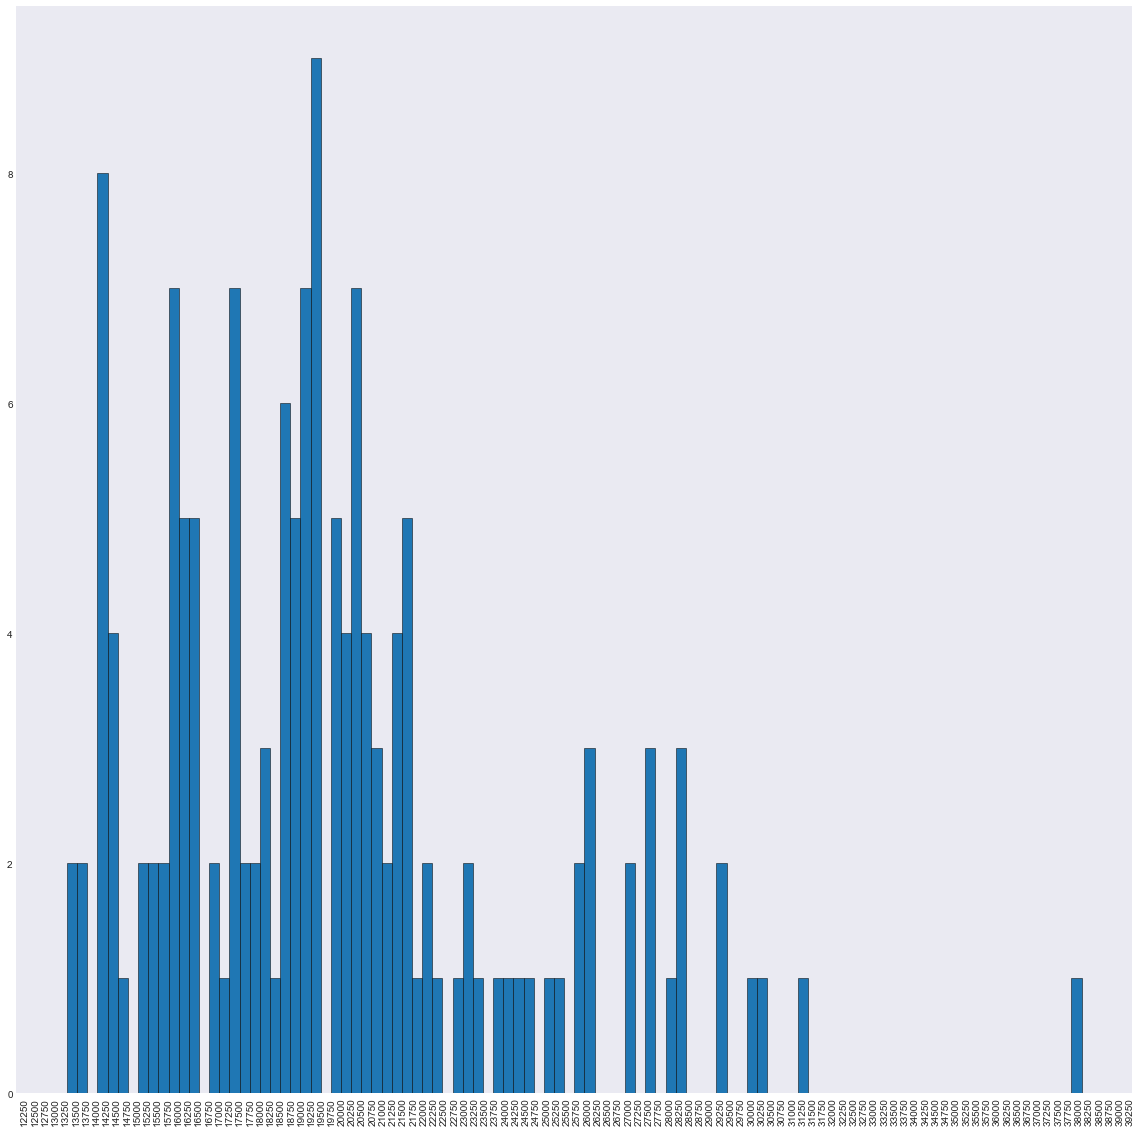

In [74]:
fig = plt.subplots(figsize = (20, 20))
plt.style.use('ggplot')
ns = 5
nbrs = NearestNeighbors(n_neighbors=ns).fit(pca_transformed_data)
distances, indices = nbrs.kneighbors(pca_transformed_data)
distances_hist=np.reshape(distances[:,1:4], (1,51*3))
plt.xticks(np.arange(0, 40000, step=250), rotation=90, fontsize=20)
plt.hist((np.reshape(distances[:,1:4], (1,51*3))).T,100,edgecolor='black')
ax=plt.gca()
ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)

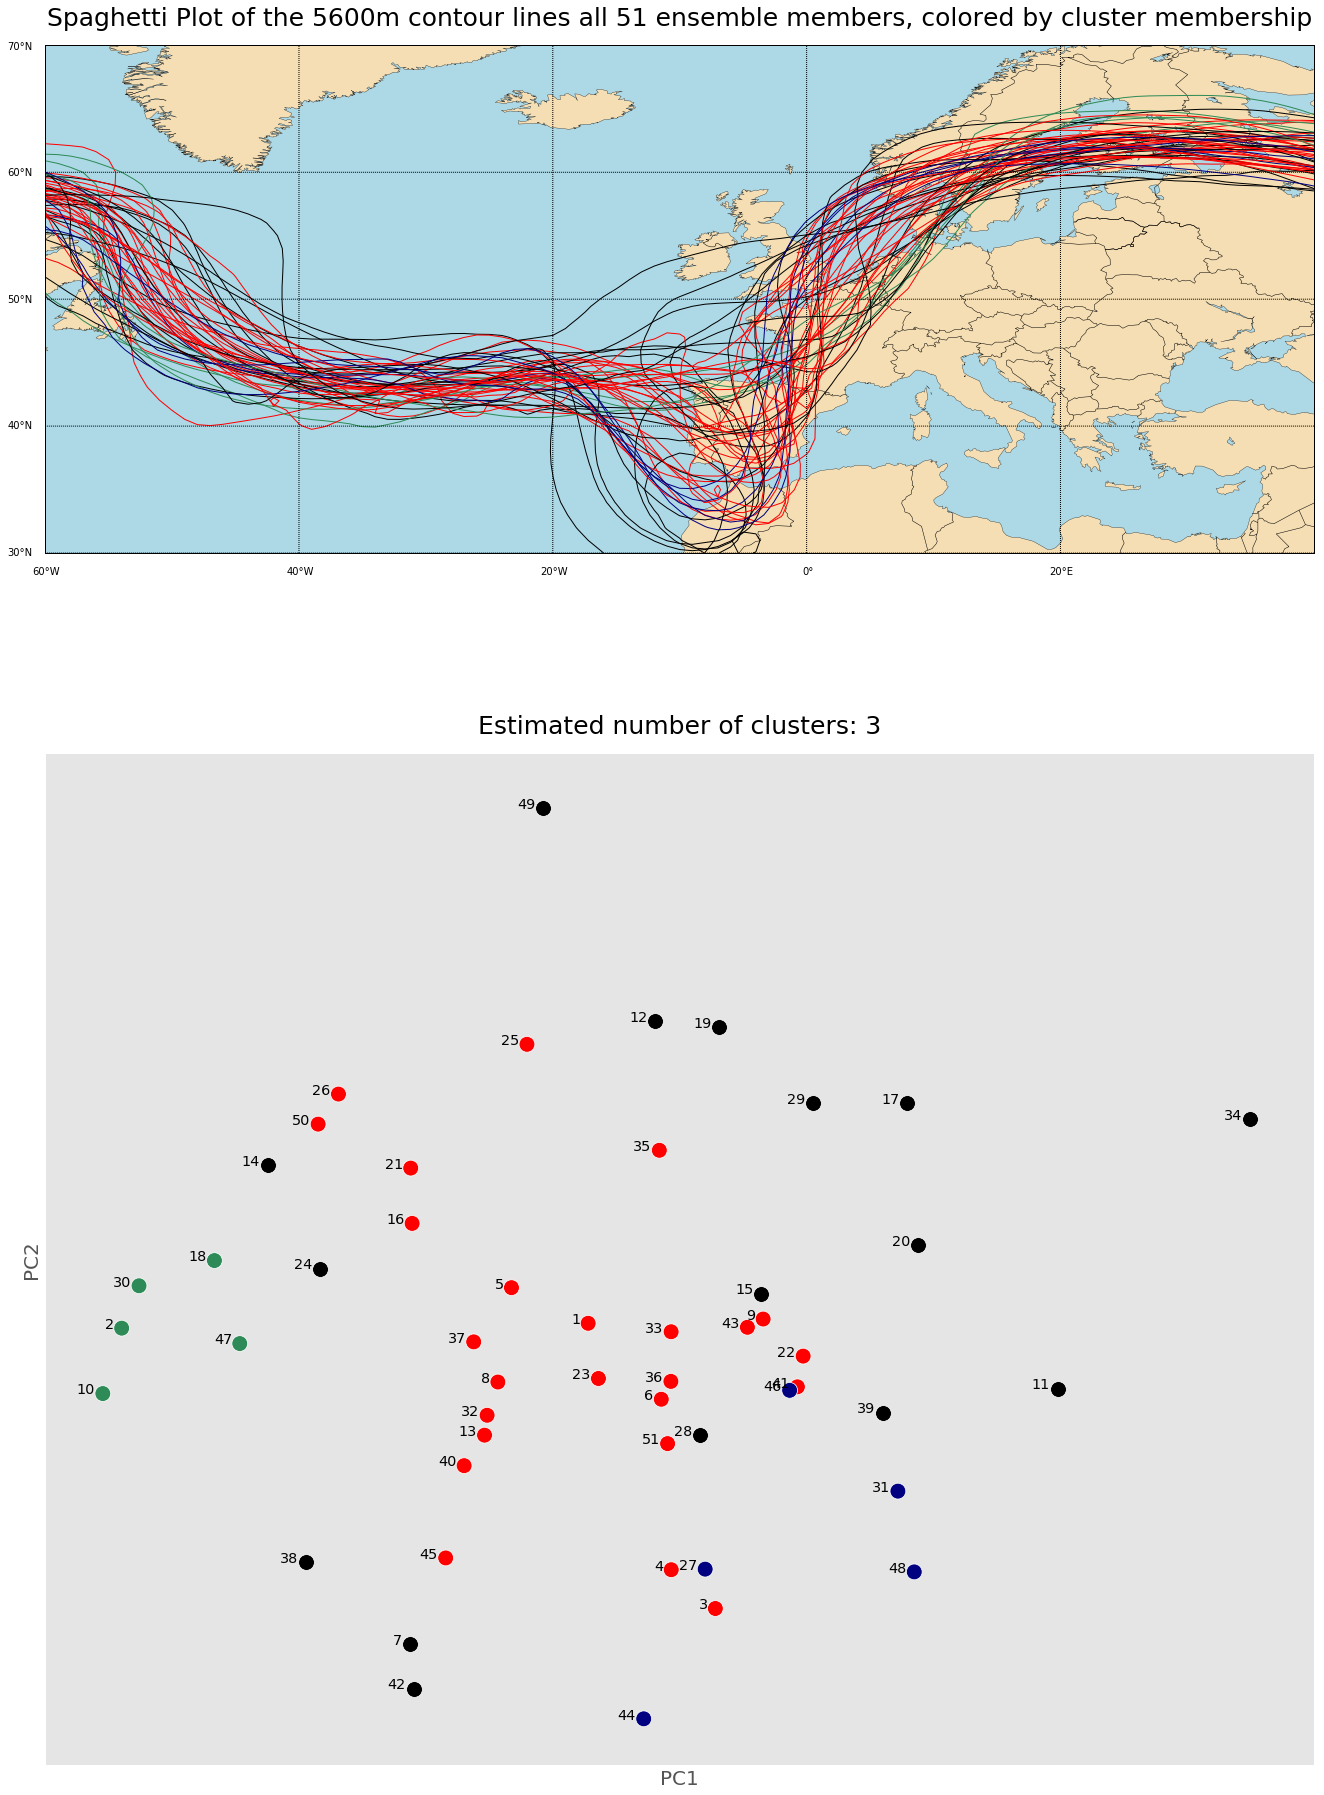

In [5]:
plt.style.use('ggplot')
db = DBSCAN(eps = 19500, min_samples = 5).fit(pca_transformed_data)
df = pd.DataFrame({'label':db.labels_,
                   'PC1':pca_transformed_data[:, 0],
                   'PC2':pca_transformed_data[:, 1]})
pp = PdfPages('DBSCAN.pdf')
fig = plt.subplots(figsize = (20, 28))
gs = gridspec.GridSpec(2, 1)
# get the cluster result in forms of labels
labels = db.labels_
# Number of clusters in labels, ignoring noise if exist.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# set color scope
arr_colors = ["red","seagreen","navy","orange","cyan"]
colors=arr_colors[0:len(set(labels)) - (1 if -1 in labels else 0)]
# extract unique label
unique_labels = set(labels)

ax0 = plt.subplot(gs[0])
ax0.set_title("Spaghetti Plot of the 5600m contour lines all 51 ensemble members, colored by cluster membership", fontsize = 25, pad = 20)
map1 = Basemap(projection ='cyl',llcrnrlat = latitude[-1], urcrnrlat = latitude[0], resolution ='l',  llcrnrlon = longitude[0], urcrnrlon = longitude[-1])
map1.drawcoastlines(linewidth = 0.3)
map1.drawmapboundary(fill_color ="lightblue")
map1.fillcontinents(color = "wheat")
map1.drawcountries()
map1.drawparallels(np.arange(30, 75, 10), labels = [True,False,False,False])
map1.drawmeridians(np.arange(-60, 40, 20), labels = [False,False,False,True])

for index, value in enumerate(labels):
    if value==-1:
        map1.contour(lon, lat, Geopotential_Isobaric_500[index, :, :], levels = [5600], colors = 'black', linewidths = 1)
    else:
        map1.contour(lon, lat, Geopotential_Isobaric_500[index, :, :], levels = [5600], colors = colors[value], linewidths = 1)


ax1 = plt.subplot(gs[1])

ax1.set_title('Estimated number of clusters: %d' % n_clusters_, fontsize = 25, pad = 20)

sp = sns.scatterplot(x="PC1", y="PC2", hue="label", data=df[df["label"]!=-1], s=250, palette=colors, legend=False)
sp1 = sns.scatterplot(x="PC1", y="PC2", data=df[df["label"]==-1], s=250, color="black", legend=False)
for line in range(0,df.shape[0]):
    if df.label[line] != -1:
         sp.text(df.PC1[line]-500, df.PC2[line], df.index[line]+1, horizontalalignment='right', size='x-large', color='black', weight='light')
    else:
        sp1.text(df.PC1[line]-500, df.PC2[line], df.index[line]+1, horizontalalignment='right', size='x-large', color='black', weight='light')

ax1.set_xticks(())
ax1.set_yticks(())
ax1.set_xlabel("PC1",{'fontsize': '20'})
ax1.set_ylabel("PC2",{'fontsize': '20'})
plt.tight_layout()

plt.savefig(pp, format='pdf', bbox_inches="tight")
pp.close()